# FINALIZED

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
from PIL import Image
from scipy.ndimage import rotate
import io
from google.colab import files
robot_img = None
try:
    image_path = 'my_robot.jpeg'
    robot_img = Image.open(image_path)
    robot_img = np.array(robot_img)
    print("Your custom robot image loaded successfully.")
except Exception as e:
    print(f"Could not load your image, will use a circle instead. Error: {e}")


#  Simulation Setup ---
WORLD_SIZE = 20.0
DT = 0.1

START_POS = np.array([2.0, 2.0])
GOAL_POS = np.array([18.0, 18.0])

MAX_LINEAR_VEL = 0.7
MAX_ANGULAR_VEL = np.deg2rad(45.0)
ROBOT_RADIUS = 0.5
IMAGE_DISPLAY_SIZE = 1.0

PREDICT_TIME = 4.0
VEL_SAMPLES = 11
ANG_VEL_SAMPLES = 21
GOAL_COST_GAIN = 1.0
OBSTACLE_COST_GAIN = 0.2
SPEED_COST_GAIN = 0.5

PET_THRESHOLD = 3.0
PERSON_THRESHOLD = 2.2
OBJECT_THRESHOLD = ROBOT_RADIUS + 0.2

class Robot:
    def __init__(self, x, y, theta):
        self.pos = np.array([x, y], dtype=float)
        self.theta = theta
        self.vel = np.array([0.0, 0.0])

    def move(self):
        self.pos[0] += self.vel[0] * np.cos(self.theta) * DT
        self.pos[1] += self.vel[0] * np.sin(self.theta) * DT
        self.theta += self.vel[1] * DT

class Obstacle:
    def __init__(self, x, y, type, p_min=0, p_max=0):
        self.pos = np.array([x, y], dtype=float)
        self.type = type
        self.vel = np.array([0.0, 0.7]) if type == 'person' else np.array([0.0, 0.5]) if type == 'pet' else np.array([0.8, 0.0])
        self.timer = 0.0
        self.p_min = p_min
        self.p_max = p_max

    def move(self):
        if self.type in ['pet', 'person']:
            self.pos[1] += self.vel[1] * DT
            if self.type == 'pet': self.pos[0] += np.sin(self.timer * 2.0) * 1.5 * DT
            self.timer += DT
            if self.pos[1] < self.p_min or self.pos[1] > self.p_max: self.vel[1] *= -1
        elif self.type == 'distractor':
            self.pos[0] += self.vel[0] * DT
            if self.pos[0] < self.p_min or self.pos[0] > self.p_max: self.vel[0] *= -1


def generate_dynamic_window(robot):
    v_min, v_max = max(0, robot.vel[0] - MAX_LINEAR_VEL * DT), min(MAX_LINEAR_VEL, robot.vel[0] + MAX_LINEAR_VEL * DT)
    w_min, w_max = max(-MAX_ANGULAR_VEL, robot.vel[1] - MAX_ANGULAR_VEL * DT), min(MAX_ANGULAR_VEL, robot.vel[1] + MAX_ANGULAR_VEL * DT)
    return np.linspace(v_min, v_max, VEL_SAMPLES), np.linspace(w_min, w_max, ANG_VEL_SAMPLES)

def simulate_trajectory(robot, v, w):
    traj, temp_pos, temp_theta = [], robot.pos.copy(), robot.theta
    for _ in np.arange(0, PREDICT_TIME, DT):
        temp_pos[0] += v * np.cos(temp_theta) * DT
        temp_pos[1] += v * np.sin(temp_theta) * DT
        temp_theta += w * DT
        traj.append(temp_pos.copy())
    return np.array(traj)

def calculate_costs(traj, goal, obstacles, v, use_social_cost):
    if use_social_cost:
        for obs in obstacles:
            min_dist_to_obs = np.min(np.linalg.norm(traj - obs.pos, axis=1))
            if obs.type == 'pet' and min_dist_to_obs < PET_THRESHOLD: return float('inf')
            if obs.type == 'person' and min_dist_to_obs < PERSON_THRESHOLD: return float('inf')
            if (obs.type == 'object' or obs.type == 'distractor') and min_dist_to_obs < OBJECT_THRESHOLD: return float('inf')

    goal_cost = np.linalg.norm(traj[-1] - goal)
    speed_cost = MAX_LINEAR_VEL - v
    min_dist_to_any_obs = float('inf')
    for obs in obstacles:
        min_dist_to_obs = np.min(np.linalg.norm(traj - obs.pos, axis=1))
        min_dist_to_any_obs = min(min_dist_to_any_obs, min_dist_to_obs)

    obstacle_cost = 1.0 / min_dist_to_any_obs if min_dist_to_any_obs > 0 else float('inf')
    return (GOAL_COST_GAIN * goal_cost + OBSTACLE_COST_GAIN * obstacle_cost + SPEED_COST_GAIN * speed_cost)

def find_best_velocity(robot, goal, obstacles, use_social_cost):
    v_space, w_space = generate_dynamic_window(robot)
    min_cost, best_vel, best_traj = float('inf'), robot.vel, np.array([robot.pos])
    for v in v_space:
        for w in w_space:
            traj = simulate_trajectory(robot, v, w)
            cost = calculate_costs(traj, goal, obstacles, v, use_social_cost)
            if cost < min_cost:
                min_cost, best_vel, best_traj = cost, np.array([v, w]), traj
    return best_vel, best_traj

def run_simulation(use_social_cost):
    robot = Robot(x=START_POS[0], y=START_POS[1], theta=np.pi / 4)
    goal = GOAL_POS

    obstacles = [ Obstacle(x=7.0, y=15.0, type='person', p_min=5.0, p_max=15.0), Obstacle(x=13.0, y=5.0, type='pet', p_min=5.0, p_max=15.0), Obstacle(x=10.0, y=10.0, type='object'), Obstacle(x=5.0, y=12.0, type='distractor', p_min=5.0, p_max=15.0) ]
    history_robot, history_theta, history_traj = [], [], []
    history_obs = {i: [] for i in range(len(obstacles))}
    min_clearances = {obs.type: float('inf') for obs in obstacles}
    collisions = []
    for step in range(600):
        history_robot.append(robot.pos.copy())
        history_theta.append(robot.theta)
        for i, obs in enumerate(obstacles):
            history_obs[i].append(obs.pos.copy())
            current_dist = np.linalg.norm(robot.pos - obs.pos)
            if current_dist <= ROBOT_RADIUS and obs.type not in collisions:
                print(f"COLLISION DETECTED with {obs.type.upper()}!")
                collisions.append(obs.type)
            if current_dist < min_clearances[obs.type]: min_clearances[obs.type] = current_dist
            obs.move()
        if np.linalg.norm(robot.pos - goal) < 0.5:
            print("Goal reached!"); break
        best_vel, best_traj = find_best_velocity(robot, goal, obstacles, use_social_cost)
        history_traj.append(best_traj)
        robot.vel = best_vel
        robot.move()
    sim_type = 'Semantic-DWA' if use_social_cost else 'Standard DWA'
    print(f"\n--- Results for {sim_type} ---")
    if collisions: print(f"!!! Collisions occurred with: {', '.join(c.upper() for c in collisions)} !!!")
    for obs_type in ['person', 'pet', 'object', 'distractor']: print(f"Min Clearance from {obs_type.capitalize()}: {min_clearances.get(obs_type, 'N/A'):.2f}m")
    return np.array(history_robot), np.array(history_theta), history_obs, history_traj

print("Running simulations...")
history_std, theta_std, obs_hist_std, traj_hist_std = run_simulation(use_social_cost=False)
history_social, theta_social, obs_hist_social, traj_hist_social = run_simulation(use_social_cost=True)


print("\nCreating 2D Top-Down Animation...")
plt.rcParams['animation.embed_limit'] = 100.0
max_frames = max(len(history_std), len(history_social))

fig_2d, (ax1_2d, ax2_2d) = plt.subplots(1, 2, figsize=(16, 8))
fig_2d.suptitle('2D Top-Down View', fontsize=16)

def plot_scene_2d(ax, title, robot_hist, theta_hist, obs_hist, traj_hist, i):
    ax.cla()
    ax.set_title(title, fontsize=14)
    ax.set_xlim(0, WORLD_SIZE)
    ax.set_ylim(0, WORLD_SIZE)
    ax.set_aspect('equal')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    current_frame_index = min(i, len(robot_hist) - 1)

    ax.plot(GOAL_POS[0], GOAL_POS[1], 'g*', markersize=20, label='Goal')
    ax.text(GOAL_POS[0], GOAL_POS[1] - 0.8, f'Goal ({GOAL_POS[0]}, {GOAL_POS[1]})', ha='center', fontsize=10, color='green')
    ax.plot(START_POS[0], START_POS[1], 'g*', markersize=15, label='Start') # Using a green star for start
    ax.text(START_POS[0], START_POS[1] - 0.8, f'Start ({START_POS[0]}, {START_POS[1]})', ha='center', fontsize=10, color='green')

    obs_pos = np.array([obs_hist[j][current_frame_index] for j in range(len(obs_hist))])
    ax.plot(obs_pos[:, 0], obs_pos[:, 1], 'ko', markersize=10, label='Obstacle')

    ax.plot(robot_hist[:current_frame_index, 0], robot_hist[:current_frame_index, 1], 'b--', alpha=0.5, linewidth=1.5, label='_nolegend_')

    if current_frame_index < len(traj_hist):
        ax.plot(traj_hist[current_frame_index][:, 0], traj_hist[current_frame_index][:, 1], 'm-', linewidth=2, alpha=0.7, label='Chosen Trajectory')

    if robot_img is not None and current_frame_index < len(robot_hist):
        rotated_img = rotate(robot_img, -np.rad2deg(theta_hist[current_frame_index]) + 90, reshape=False)
        ax.imshow(rotated_img, extent=(robot_hist[current_frame_index, 0] - IMAGE_DISPLAY_SIZE / 2, robot_hist[current_frame_index, 0] + IMAGE_DISPLAY_SIZE / 2,
                                     robot_hist[current_frame_index, 1] - IMAGE_DISPLAY_SIZE / 2, robot_hist[current_frame_index, 1] + IMAGE_DISPLAY_SIZE / 2), zorder=11)
    elif current_frame_index < len(robot_hist):
        robot_circle = Circle(robot_hist[current_frame_index], ROBOT_RADIUS, color='blue', fill=False, zorder=11)
        ax.add_patch(robot_circle)
        ax.plot([robot_hist[current_frame_index,0], robot_hist[current_frame_index,0] + ROBOT_RADIUS * np.cos(theta_hist[current_frame_index])],
                [robot_hist[current_frame_index,1], robot_hist[current_frame_index,1] + ROBOT_RADIUS * np.sin(theta_hist[current_frame_index])], 'b-', linewidth=2)

    ax.legend(loc='upper left')

def animate_2d(i):
    plot_scene_2d(ax1_2d, "Standard DWA", history_std, theta_std, obs_hist_std, traj_hist_std, i)
    plot_scene_2d(ax2_2d, "Semantic-DWA (with Social Cost)", history_social, theta_social, obs_hist_social, traj_hist_social, i)

ani_2d = FuncAnimation(fig_2d, animate_2d, frames=max_frames, interval=50, blit=False)
plt.close(fig_2d)

animation_filename = 'simulation_animation.html'
html_animation = ani_2d.to_jshtml()
with open(animation_filename, 'w') as f:
    f.write(html_animation)
print(f"Animation saved as {animation_filename}. Triggering download...")
files.download(animation_filename)

Could not load your image, will use a circle instead. Error: [Errno 2] No such file or directory: 'my_robot.jpeg'
Running simulations...
COLLISION DETECTED with PERSON!
COLLISION DETECTED with OBJECT!
COLLISION DETECTED with PET!
Goal reached!

--- Results for Standard DWA ---
!!! Collisions occurred with: PERSON, OBJECT, PET !!!
Min Clearance from Person: 0.35m
Min Clearance from Pet: 0.36m
Min Clearance from Object: 0.47m
Min Clearance from Distractor: 1.74m
Goal reached!

--- Results for Semantic-DWA ---
Min Clearance from Person: 1.00m
Min Clearance from Pet: 2.08m
Min Clearance from Object: 0.70m
Min Clearance from Distractor: 0.76m

Creating 2D Top-Down Animation...
Animation saved as simulation_animation.html. Triggering download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Running Standard DWA...
Goal reached!

--- Results for Standard DWA ---
!!! Collisions occurred with: PERSON, OBJECT, PET !!!
Overall min clearance: 0.345 m

Running Semantic-DWA (with social cost)...
Goal reached!

--- Results for Semantic-DWA ---
Overall min clearance: 0.700 m

Plot saved as dwa_comparison.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

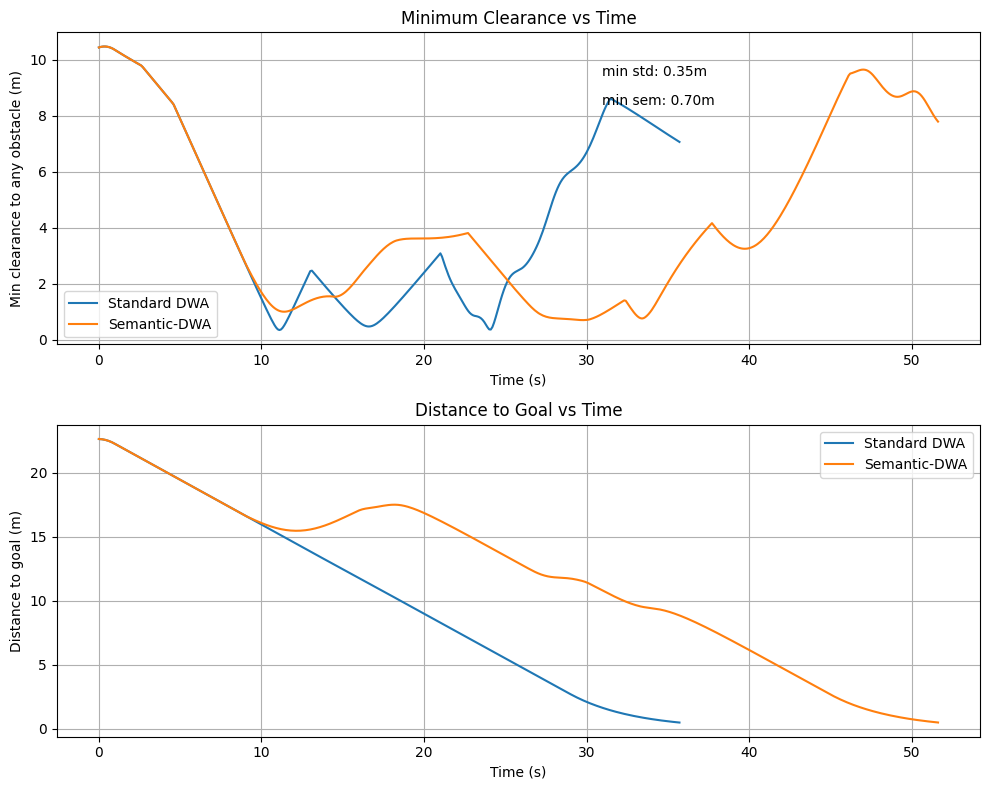


Summary:
Standard DWA - overall min clearance: 0.345 m, collisions: ['person', 'object', 'pet']
Semantic DWA - overall min clearance: 0.700 m, collisions: []


In [5]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.ndimage import rotate
from PIL import Image
from google.colab import files

WORLD_SIZE = 20.0
DT = 0.1

START_POS = np.array([2.0, 2.0])
GOAL_POS = np.array([18.0, 18.0])

MAX_LINEAR_VEL = 0.7
MAX_ANGULAR_VEL = np.deg2rad(45.0)
ROBOT_RADIUS = 0.5

PREDICT_TIME = 4.0
VEL_SAMPLES = 11
ANG_VEL_SAMPLES = 21
GOAL_COST_GAIN = 1.0
OBSTACLE_COST_GAIN = 0.2
SPEED_COST_GAIN = 0.5

PET_THRESHOLD = 3.0
PERSON_THRESHOLD = 2.2
OBJECT_THRESHOLD = ROBOT_RADIUS + 0.2

robot_img = None
try:
    robot_img = Image.open('my_robot.jpeg')
    robot_img = np.array(robot_img)
except:
    robot_img = None

class Robot:
    def __init__(self, x, y, theta):
        self.pos = np.array([x, y], dtype=float)
        self.theta = theta
        self.vel = np.array([0.0, 0.0])
    def move(self):
        self.pos[0] += self.vel[0] * np.cos(self.theta) * DT
        self.pos[1] += self.vel[0] * np.sin(self.theta) * DT
        self.theta += self.vel[1] * DT

class Obstacle:
    def __init__(self, x, y, type, p_min=0, p_max=0):
        self.pos = np.array([x, y], dtype=float)
        self.type = type
        self.vel = np.array([0.0, 0.7]) if type == 'person' else np.array([0.0, 0.5]) if type == 'pet' else np.array([0.8, 0.0])
        self.timer = 0.0
        self.p_min = p_min
        self.p_max = p_max
    def move(self):
        if self.type in ['pet', 'person']:
            self.pos[1] += self.vel[1] * DT
            if self.type == 'pet':
                self.pos[0] += np.sin(self.timer * 2.0) * 1.5 * DT
            self.timer += DT
            if self.pos[1] < self.p_min or self.pos[1] > self.p_max:
                self.vel[1] *= -1
        elif self.type == 'distractor':
            self.pos[0] += self.vel[0] * DT
            if self.pos[0] < self.p_min or self.pos[0] > self.p_max:
                self.vel[0] *= -1

def generate_dynamic_window(robot):
    v_min = max(0, robot.vel[0] - MAX_LINEAR_VEL * DT)
    v_max = min(MAX_LINEAR_VEL, robot.vel[0] + MAX_LINEAR_VEL * DT)
    w_min = max(-MAX_ANGULAR_VEL, robot.vel[1] - MAX_ANGULAR_VEL * DT)
    w_max = min(MAX_ANGULAR_VEL, robot.vel[1] + MAX_ANGULAR_VEL * DT)
    return np.linspace(v_min, v_max, VEL_SAMPLES), np.linspace(w_min, w_max, ANG_VEL_SAMPLES)

def simulate_trajectory(robot, v, w):
    traj, temp_pos, temp_theta = [], robot.pos.copy(), robot.theta
    for _ in np.arange(0, PREDICT_TIME, DT):
        temp_pos[0] += v * np.cos(temp_theta) * DT
        temp_pos[1] += v * np.sin(temp_theta) * DT
        temp_theta += w * DT
        traj.append(temp_pos.copy())
    return np.array(traj)

def calculate_costs(traj, goal, obstacles, v, use_social_cost):
    if use_social_cost:
        for obs in obstacles:
            min_dist_to_obs = np.min(np.linalg.norm(traj - obs.pos, axis=1))
            if obs.type == 'pet' and min_dist_to_obs < PET_THRESHOLD: return float('inf')
            if obs.type == 'person' and min_dist_to_obs < PERSON_THRESHOLD: return float('inf')
            if (obs.type == 'object' or obs.type == 'distractor') and min_dist_to_obs < OBJECT_THRESHOLD: return float('inf')
    goal_cost = np.linalg.norm(traj[-1] - goal)
    speed_cost = MAX_LINEAR_VEL - v
    min_dist_to_any_obs = float('inf')
    for obs in obstacles:
        min_dist_to_obs = np.min(np.linalg.norm(traj - obs.pos, axis=1))
        min_dist_to_any_obs = min(min_dist_to_any_obs, min_dist_to_obs)
    obstacle_cost = 1.0 / min_dist_to_any_obs if min_dist_to_any_obs > 0 else float('inf')
    return (GOAL_COST_GAIN * goal_cost + OBSTACLE_COST_GAIN * obstacle_cost + SPEED_COST_GAIN * speed_cost)

def find_best_velocity(robot, goal, obstacles, use_social_cost):
    v_space, w_space = generate_dynamic_window(robot)
    min_cost = float('inf'); best_vel = robot.vel; best_traj = np.array([robot.pos])
    for v in v_space:
        for w in w_space:
            traj = simulate_trajectory(robot, v, w)
            cost = calculate_costs(traj, goal, obstacles, v, use_social_cost)
            if cost < min_cost:
                min_cost, best_vel, best_traj = cost, np.array([v, w]), traj
    return best_vel, best_traj

def run_simulation(use_social_cost, max_steps=600, verbose=False):
    robot = Robot(x=START_POS[0], y=START_POS[1], theta=np.pi / 4)
    goal = GOAL_POS.copy()
    obstacles = [
        Obstacle(x=7.0, y=15.0, type='person', p_min=5.0, p_max=15.0),
        Obstacle(x=13.0, y=5.0, type='pet', p_min=5.0, p_max=15.0),
        Obstacle(x=10.0, y=10.0, type='object'),
        Obstacle(x=5.0, y=12.0, type='distractor', p_min=5.0, p_max=15.0)
    ]
    history_robot = []
    history_theta = []
    history_traj = []
    history_obs = {i: [] for i in range(len(obstacles))}
    min_clearances_over_time = []
    dist_to_goal_over_time = []
    collisions = []
    overall_min_clearance = float('inf')

    for step in range(max_steps):
        history_robot.append(robot.pos.copy())
        history_theta.append(robot.theta)
        current_min_dist = float('inf')
        for i, obs in enumerate(obstacles):
            history_obs[i].append(obs.pos.copy())
            current_dist = np.linalg.norm(robot.pos - obs.pos)
            current_min_dist = min(current_min_dist, current_dist)
            if current_dist <= ROBOT_RADIUS and obs.type not in collisions:
                collisions.append(obs.type)
            obs.move()
        min_clearances_over_time.append(current_min_dist)
        overall_min_clearance = min(overall_min_clearance, current_min_dist)
        dist_to_goal_over_time.append(np.linalg.norm(robot.pos - goal))

        if np.linalg.norm(robot.pos - goal) < 0.5:
            if verbose: print("Goal reached!")
            break

        best_vel, best_traj = find_best_velocity(robot, goal, obstacles, use_social_cost)
        history_traj.append(best_traj)
        robot.vel = best_vel
        robot.move()

    sim_type = 'Semantic-DWA' if use_social_cost else 'Standard DWA'
    if verbose:
        print(f"\n--- Results for {sim_type} ---")
        if collisions:
            print(f"!!! Collisions occurred with: {', '.join(c.upper() for c in collisions)} !!!")
        print(f"Overall min clearance: {overall_min_clearance:.3f} m")
    return {
        'robot_hist': np.array(history_robot),
        'theta_hist': np.array(history_theta),
        'obs_hist': history_obs,
        'traj_hist': history_traj,
        'min_clearances_over_time': np.array(min_clearances_over_time),
        'dist_to_goal_over_time': np.array(dist_to_goal_over_time),
        'collisions': collisions,
        'overall_min_clearance': overall_min_clearance
    }

print("Running Standard DWA...")
std = run_simulation(use_social_cost=False, verbose=True)

print("\nRunning Semantic-DWA (with social cost)...")
sem = run_simulation(use_social_cost=True, verbose=True)

plt.figure(figsize=(10, 8))

plt.subplot(2,1,1)
t_std = np.arange(len(std['min_clearances_over_time'])) * DT
t_sem = np.arange(len(sem['min_clearances_over_time'])) * DT
plt.plot(t_std, std['min_clearances_over_time'], label='Standard DWA', linewidth=1.5)
plt.plot(t_sem, sem['min_clearances_over_time'], label='Semantic-DWA', linewidth=1.5)
plt.xlabel('Time (s)')
plt.ylabel('Min clearance to any obstacle (m)')
plt.title('Minimum Clearance vs Time')
plt.grid(True)
plt.legend()
plt.annotate(f'min std: {std["overall_min_clearance"]:.2f}m', xy=(t_std[-1] if len(t_std)>0 else 0, std['min_clearances_over_time'][-1] if len(std['min_clearances_over_time'])>0 else 0),
             xytext=(0.6*max(t_std.max() if len(t_std)>0 else 1, t_sem.max() if len(t_sem)>0 else 1), 0.9*max(std['min_clearances_over_time'].max() if len(std['min_clearances_over_time'])>0 else 1, sem['min_clearances_over_time'].max() if len(sem['min_clearances_over_time'])>0 else 1)))

plt.annotate(f'min sem: {sem["overall_min_clearance"]:.2f}m', xy=(t_sem[-1] if len(t_sem)>0 else 0, sem['min_clearances_over_time'][-1] if len(sem['min_clearances_over_time'])>0 else 0),
             xytext=(0.6*max(t_std.max() if len(t_std)>0 else 1, t_sem.max() if len(t_sem)>0 else 1), 0.8*max(std['min_clearances_over_time'].max() if len(std['min_clearances_over_time'])>0 else 1, sem['min_clearances_over_time'].max() if len(sem['min_clearances_over_time'])>0 else 1)))


plt.subplot(2,1,2)
plt.plot(t_std, std['dist_to_goal_over_time'], label='Standard DWA', linewidth=1.5)
plt.plot(t_sem, sem['dist_to_goal_over_time'], label='Semantic-DWA', linewidth=1.5)
plt.xlabel('Time (s)')
plt.ylabel('Distance to goal (m)')
plt.title('Distance to Goal vs Time')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig('dwa_comparison.png', dpi=200)
print("\nPlot saved as dwa_comparison.png")
files.download('dwa_comparison.png')
plt.show()

# --- Print summary stats ---
print("\nSummary:")
print(f"Standard DWA - overall min clearance: {std['overall_min_clearance']:.3f} m, collisions: {std['collisions']}")
print(f"Semantic DWA - overall min clearance: {sem['overall_min_clearance']:.3f} m, collisions: {sem['collisions']}")
